In [16]:
from sklearn import tree
from sklearn.metrics import accuracy_score
import pydot
import numpy as np
import random
from numpy.random import RandomState
from scipy import stats
import math
import graphviz
from six import StringIO
import pandas as pd

In [17]:
data_data = pd.read_csv('/Users/mac/Documents/code/data mining/Assignment/Assignment2/DT/skysurvey/training_data.csv')
data_class = pd.read_csv('/Users/mac/Documents/code/data mining/Assignment/Assignment2/DT/skysurvey/training_class.csv')

In [18]:
clf = tree.DecisionTreeClassifier(criterion='gini', min_samples_leaf=0.01,  random_state=RandomState(2018))
clf = clf.fit(data_data, data_class)

In [19]:
#to visualize the decision tree
feature_names = ['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'rerun', 'camcol', 'field', 'specobjid', 'redshift', 'plate', 'mjd', 'fiberid']
class_names = ['STAR', 'GALAXY', 'QUASAR']
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=feature_names,  
                         class_names=class_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  


graphv = graphviz.Source(dot_data) 

In [20]:
dot_data = StringIO()
tree.export_graphviz(clf, out_file=dot_data, feature_names=feature_names,  
                         class_names=class_names,  
                         filled=True, rounded=True,  
                         special_characters=True  
                    )
graph = pydot.graph_from_dot_data(dot_data.getvalue())
graph[0].write_pdf("/Users/mac/Documents/code/data mining/Assignment/Assignment2/DT/SDSS.pdf")

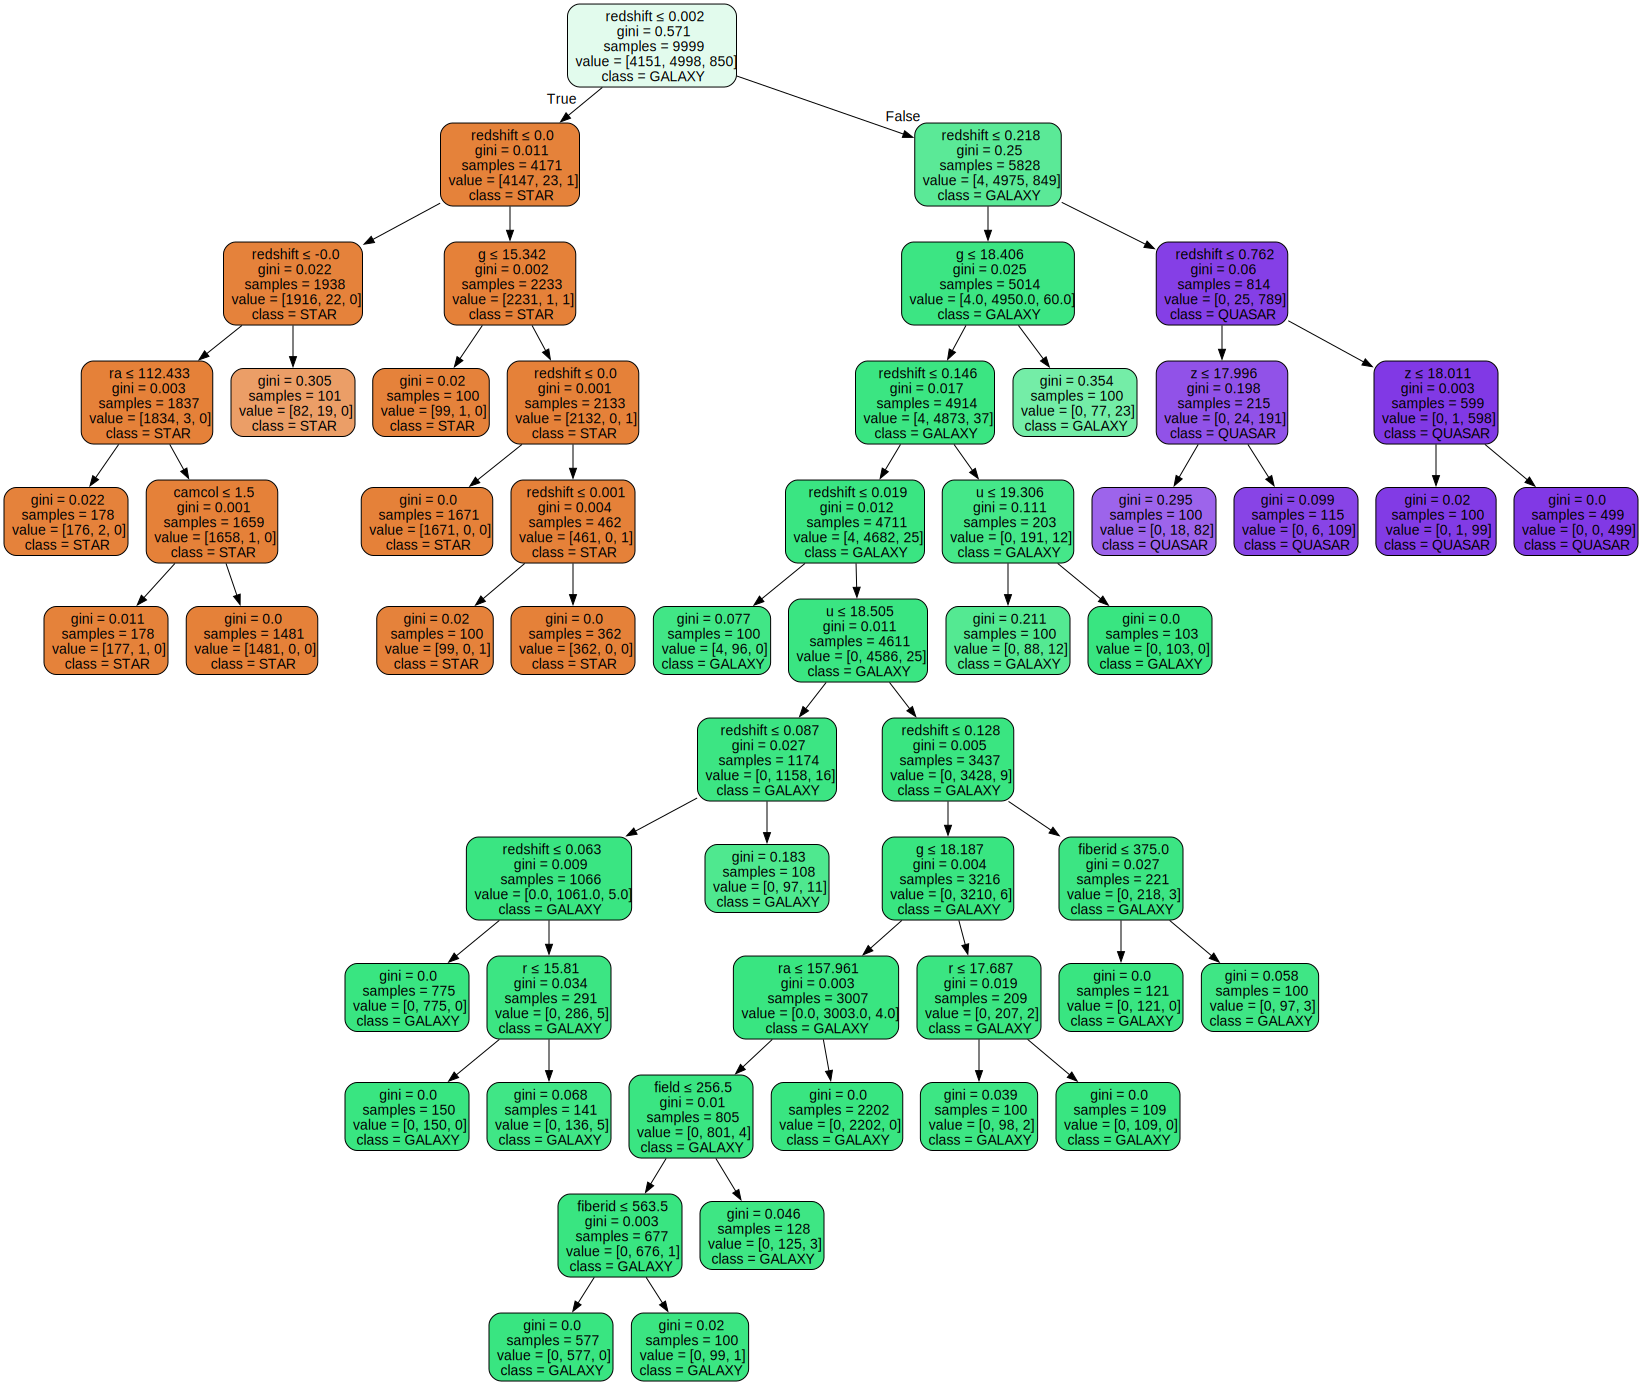

In [21]:
graphv

In [22]:
print("Training errors: " + str((1 - clf.score(data_data, data_class))))

Training errors: 0.01130113011301126


In [23]:
print ("Number of nodes in the tree: " + str(clf.tree_.node_count))

Number of nodes in the tree: 55


In [24]:
# Step 1: Count the number of leaves
def count_leaves(decision_tree):
    tree_ = decision_tree.tree_
    is_leaf = (tree_.children_left == -1) & (tree_.children_right == -1)
    num_leaves = np.count_nonzero(is_leaf)
    return num_leaves

num_leaves = count_leaves(clf)
print("Number of leaves in the tree:", num_leaves)

# Step 2: Calculate training error
def count_leaf_errors(decision_tree, X, y):
    y = y.values.flatten()  # Ensure y is a 1D array
    tree_ = decision_tree.tree_
    leaf_indices = decision_tree.apply(X)
    errors = 0
    
    for leaf_index in np.unique(leaf_indices):
        # get the samples in the leaf node
        sample_indices = np.where(leaf_indices == leaf_index)[0]
        # get the majority class in the leaf node
        leaf_prediction = np.argmax(np.bincount(y[sample_indices]))
        # count the errors
        errors += np.sum(y[sample_indices] != leaf_prediction)
    
    return errors

training_error = count_leaf_errors(clf, data_data, data_class)

# Step 3: Estimate generalization error using penalty term
alpha = 0.5  # Penalty term per leaf node
generalization_error = training_error + alpha * num_leaves
print("Estimated Generalization Error:", generalization_error)

Number of leaves in the tree: 28
Estimated Generalization Error: 127.0


In [25]:
clf_up = tree.DecisionTreeClassifier(criterion='gini', min_samples_leaf=0.01, max_depth=2, random_state=RandomState(2018))
clf_up = clf_up.fit(data_data, data_class)

#to visualize the decision tree
feature_names = ['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'rerun', 'camcol', 'field', 'specobjid', 'redshift', 'plate', 'mjd', 'fiberid']
class_names = ['STAR', 'GALAXY', 'QUASAR']
dot_data = tree.export_graphviz(clf_up, out_file=None, 
                         feature_names=feature_names,  
                         class_names=class_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  


graphv = graphviz.Source(dot_data) 

dot_data = StringIO()
tree.export_graphviz(clf_up, out_file=dot_data, feature_names=feature_names,  
                         class_names=class_names,  
                         filled=True, rounded=True,  
                         special_characters=True  
                    )
graph = pydot.graph_from_dot_data(dot_data.getvalue())
graph[0].write_pdf("/Users/mac/Documents/code/data mining/Assignment/Assignment2/DT/SDSS_best.pdf")

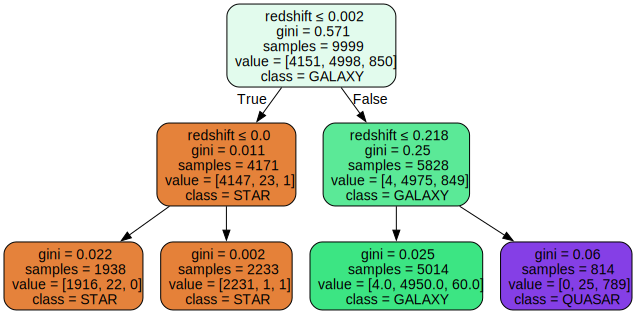

In [26]:
graphv

In [27]:
print("Training errors: " + str((1 - clf_up.score(data_data, data_class))))
print ("Number of errors in the tree: " + str((1 - clf_up.score(data_data, data_class))*len(data_data)))

Training errors: 0.01130113011301126
Number of errors in the tree: 112.99999999999959


In [28]:
# Step 1: Count the number of leaves
def count_leaves(decision_tree):
    tree_ = decision_tree.tree_
    is_leaf = (tree_.children_left == -1) & (tree_.children_right == -1)
    num_leaves = np.count_nonzero(is_leaf)
    return num_leaves

num_leaves = count_leaves(clf_up)
print("Number of leaves in the tree:", num_leaves)

# Step 2: Calculate training error
def count_leaf_errors(decision_tree, X, y):
    y = y.values.flatten()  # Ensure y is a 1D array
    tree_ = decision_tree.tree_
    leaf_indices = decision_tree.apply(X)
    errors = 0
    
    for leaf_index in np.unique(leaf_indices):
        # get the samples in the leaf node
        sample_indices = np.where(leaf_indices == leaf_index)[0]
        # get the majority class in the leaf node
        leaf_prediction = np.argmax(np.bincount(y[sample_indices]))
        # count the errors
        errors += np.sum(y[sample_indices] != leaf_prediction)
    
    return errors

training_error = count_leaf_errors(clf_up, data_data, data_class)

# Step 3: Estimate generalization error using penalty term
alpha = 0.5  # Penalty term per leaf node
generalization_error = training_error + alpha * num_leaves
print("Estimated Generalization Error:", generalization_error)

Number of leaves in the tree: 4
Estimated Generalization Error: 115.0


In [36]:
def get_generalization_error(tree, X, y, alpha):
		num_leaves = count_leaves(tree)
		training_error = count_leaf_errors(tree, X, y)
		return training_error + alpha * num_leaves

def prune_tree(decision_tree, X, y, alpha=0.5):
	tree_ = decision_tree.tree_
	best_tree = decision_tree

	def prune_node(node, best_generalization_error=115.0):
		if tree_.children_left[node] == -1 and tree_.children_right[node] == -1:
			return  # This is a leaf node, no need to prune

		# Prune left and right children
		if tree_.children_left[node] != -1:
			prune_node(tree_.children_left[node])
		if tree_.children_right[node] != -1:
			prune_node(tree_.children_right[node])

		# Temporarily prune this node
		left_child = tree_.children_left[node]
		right_child = tree_.children_right[node]
		tree_.children_left[node] = -1
		tree_.children_right[node] = -1

		# Calculate generalization error after pruning
		generalization_error = get_generalization_error(decision_tree, X, y, alpha) - 1

		# If pruning improves generalization error, keep the pruning
		if generalization_error < best_generalization_error:
			best_generalization_error = generalization_error
			best_tree = tree.DecisionTreeClassifier(criterion='gini', min_samples_leaf=0.01, random_state=RandomState(2018))
			best_tree.tree_ = tree_
		else:
			# Revert the pruning
			tree_.children_left[node] = left_child
			tree_.children_right[node] = right_child

	# Start pruning from the last leaf node
	for node in range(tree_.node_count - 1, -1, -1):
		prune_node(node)
	return best_tree

# Prune the tree
pruned_clf = prune_tree(clf_up, data_data, data_class)
print("Best Generalization Error after pruning:", get_generalization_error(pruned_clf, data_data, data_class, alpha) - 1)

# Visualize the pruned decision tree
feature_names = ['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'rerun', 'camcol', 'field', 'specobjid', 'redshift', 'plate', 'mjd', 'fiberid']
class_names = ['STAR', 'GALAXY', 'QUASAR']
dot_data = tree.export_graphviz(pruned_clf, out_file=None, 
                         feature_names=feature_names,  
                         class_names=class_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  


graphv = graphviz.Source(dot_data) 

dot_data = StringIO()
tree.export_graphviz(pruned_clf, out_file=dot_data, feature_names=feature_names,  
                         class_names=class_names,  
                         filled=True, rounded=True,  
                         special_characters=True  
                    )
graph = pydot.graph_from_dot_data(dot_data.getvalue())
graph[0].write_pdf("/Users/mac/Documents/code/data mining/Assignment/Assignment2/DT/SDSS_best_pruned.pdf")

Best Generalization Error after pruning: 114.5


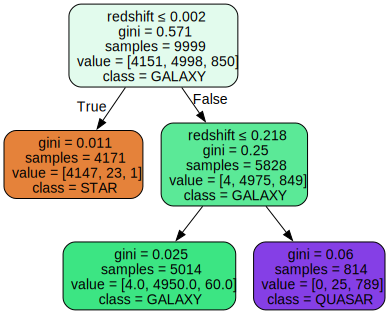

In [37]:
graphv